In [1]:
import sys
path_to_challenge_sncf_2024 = '/Users/gurvanrichardeau/Python_projects/LocalCodes/challenge_sncf_2024'
sys.path.append(path_to_challenge_sncf_2024 + '/utils')

from PandasToolsFunction import *
from DataPreprocessingTools import *

import pandas as pd
from tqdm import tqdm
import json

import matplotlib.pyplot as plt

In [75]:
class AverageModel():
    def __init__(self, train_data: pd.DataFrame, day_types = ['job', 'ferie', 'vacances']) -> None:
        self.train_data = train_data
        self.day_types = day_types
        self.station_day_type_map = {}

        self.submission = None

    def basic_train(self):
        """
        Computes day_type and station wise averages.
        """
        data = self.train_data.copy() # Ensure it does not modify original data.

        for station in tqdm(data['station'].unique()):
            station_count = 0
            for day_type in self.day_types: # Our day types will form a partition.
                mask = (data['station'] == station) & (data['day_type'] == day_type)
                station_day_type_data = data[mask]
                avg = station_day_type_data['y'].mean()
                key = f"{station}_{day_type}"  
                self.station_day_type_map[key] = avg

    def train(self, mode='basic'):
        self.station_day_type_map = {} # Reset the model.
        if mode == 'basic':
            self.basic_train()
        else :
            pass
 
    def save(self, name = "avg_model"):
        with open("avg_saved_models/" + name + ".json", 'w') as json_file:
            json.dump(self.station_day_type_map, json_file)

    def load(self, name="avg_model"):
        with open("avg_saved_models/" + name + ".json", 'r') as json_file:
            self.station_day_type_map = json.load(json_file)

    def infer(self, test_data_init: pd.DataFrame):
        """
        Assume test_data has a column station and one for each day type.
        """
        test_data = test_data_init.copy()
        

        for index, row in test_data.iterrows():
            station, day_type = row['station'], row['day_type']
            key = f"{station}_{day_type}"
            test_data.at[index, 'y'] = self.station_day_type_map[key]

        self.submission = test_data[['index', 'y']]
        return test_data
    
    def save_submission(self, name = "submission"):
        self.submission.to_csv("submissions/" + name + ".csv", index=False)    

100%|██████████| 2/2 [00:09<00:00,  4.80s/it]


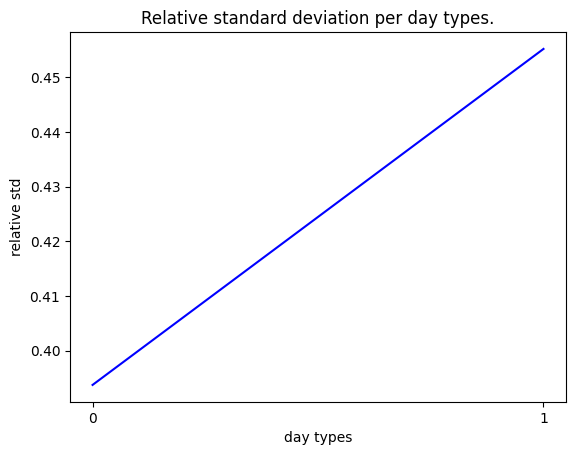

In [ ]:
avg_basic_basic_model = AverageModel2(train_data, day_type_col='day_type')
avg_basic_basic_model.train(plot_rel_std=True)
avg_basic_basic_model.save('avg_basic_basic_model')

In [72]:
class AverageModelOld():
    def __init__(self, train_data: pd.DataFrame, day_type_col = 'day_full_type') -> None:
        self.train_data = train_data

        self.day_type_col = day_type_col
        self.day_types = train_data[day_type_col].unique()
        self.day_types.sort()

        self.station_day_type_map = {}
        self.STDs = {}

        self.submission = None

    def basic_train(self, plot_rel_std: bool):
        """
        Computes day_type and station wise averages.
        """
        data = self.train_data.copy() # Ensure it does not modify original data.
        
        for day_type in tqdm(self.day_types) : 
            relative_std = 0.
            station_count = len(data['station'].unique())
            for station in data['station'].unique():
                mask = (data['station'] == station) & (data[self.day_type_col] == day_type)
                y_values = data[mask]['y']
                mean, std = y_values.mean(), y_values.std() # if only one y_value std returns nan (which actually is considered as a np.float...)
                if len(y_values) < 2 or mean == 0 :
                    station_count -= 1 # Because we drop a datapoint, we need to average on less stations.    
                elif plot_rel_std :
                    relative_std += std/mean # Compute relative standard deviation
                
                if len(y_values)>=1 :
                    key = f"{station}_{day_type}"  
                    self.station_day_type_map[key] = mean
                    
            std_key = str(day_type) #json dict does not allow int as key. 
            #if station_count > 0 : self.STDs[std_key] = relative_std/station_count # shouldn't be necessary to check
            self.STDs[std_key] = relative_std/station_count 
                
        if plot_rel_std : plot_STD_data(self.STDs)

    def train(self, mode='basic', plot_rel_std:bool = False):
        self.station_day_type_map = {} # Reset the model.
        if mode == 'basic':
            self.basic_train(plot_rel_std)
        else :
            pass
 
    def save(self, name = "avg_model"):
        with open("avg_saved_models/" + name + ".json", 'w') as json_file:
            json.dump(self.station_day_type_map, json_file)
        with open("std_saved/" + name + ".json", 'w') as json_file:
            json.dump(self.STDs, json_file)

    def load(self, name="avg_model"):
        with open("avg_saved_models/" + name + ".json", 'r') as json_file:
            self.station_day_type_map = json.load(json_file)

    def infer(self, test_data_init: pd.DataFrame):
        """
        Assume test_data has a column station and one for each day type.
        Think about the fact that some day types of 2023 could not be in self.day_types of 2018-2022
        Means that we should make a rule like : 
        if day_type not in infer_dict :
            apply rule corresponding to the day of week

        Also would be interesting to count how many are there (+ 25 from 2018 to 2019)
        --> here is probably the interest of machine learning, because we don't have enough data to cover all the day_types.
        --> Which induces a poor robustness to new day_type.
        """
        test_data = test_data_init.copy()
        

        missed_key_count = 0
        for index, row in test_data.iterrows():
            station, day_type = row['station'], row[self.day_type_col]
            key = f"{station}_{day_type}"
            if key in self.station_day_type_map.keys():
                test_data.at[index, 'y'] = self.station_day_type_map[key]
            
            else : 
                # try for every other month
                day_type = str(day_type)
                if day_type[-1] == '0' : day_type = day_type[:-1] + '1'
                elif day_type[-1] == '1' : day_type = day_type[:-1] + '0'
                month = int(day_type[:-2])
                month_count = 0
                while key not in self.station_day_type_map.keys() or month_count <12 :
                    month += 1
                    month = month % 13
                    if month == 0: month+=1 # in order to never be on mothn 0 which corresponds to nothing
                    
                    day_type = str(month) + day_type[-2:]
                    key = f"{station}_{day_type}"
                    month_count +=1
                if month_count >= 12 :
                    missed_key_count+=1
                    key_for_basic_basic = f"{station}_{day_type[-1]}"
                    test_data.at[index, 'y'] = avg_basic_basic_model.station_day_type_map[key_for_basic_basic]
                else :
                    test_data.at[index, 'y'] = self.station_day_type_map[key]
            
        print(f"{missed_key_count = }")
        self.submission = test_data[['index', 'y']]
        return test_data
    
    def save_submission(self, name = "submission"):
        self.submission.to_csv("../submissions/" + name + ".csv", index=False)    

In [ ]:
class AverageModel2():
    def __init__(self, train_data: pd.DataFrame, day_type_col = 'day_full_type') -> None:
        self.train_data = train_data

        self.day_type_col = day_type_col
        self.day_types = train_data[day_type_col].unique()
        self.day_types.sort()

        self.station_day_type_map = {}
        self.STDs = {}

        self.submission = None

    def basic_train(self, plot_rel_std: bool):
        """
        Computes day_type and station wise averages.
        """
        data = self.train_data.copy() # Ensure it does not modify original data.
        
        for day_type in tqdm(self.day_types) : 
            relative_std = 0.
            station_count = len(data['station'].unique())
            for station in data['station'].unique():
                mask = (data['station'] == station) & (data[self.day_type_col] == day_type)
                y_values = data[mask]['y']
                mean, std = y_values.mean(), y_values.std() # if only one y_value std returns nan (which actually is considered as a np.float...)
                if len(y_values) < 2 or mean == 0 :
                    station_count -= 1 # Because we drop a datapoint, we need to average on less stations.    
                elif plot_rel_std :
                    relative_std += std/mean # Compute relative standard deviation
                
                if len(y_values)>=1 :
                    key = f"{station}_{day_type}"  
                    self.station_day_type_map[key] = mean
                    
            std_key = str(day_type) #json dict does not allow int as key. 
            #if station_count > 0 : self.STDs[std_key] = relative_std/station_count # shouldn't be necessary to check
            self.STDs[std_key] = relative_std/station_count 
                
        if plot_rel_std : plot_STD_data(self.STDs)

    def train(self, mode='basic', plot_rel_std:bool = False):
        self.station_day_type_map = {} # Reset the model.
        if mode == 'basic':
            self.basic_train(plot_rel_std)
        else :
            pass
 
    def save(self, name = "avg_model"):
        with open("avg_saved_models/" + name + ".json", 'w') as json_file:
            json.dump(self.station_day_type_map, json_file)
        with open("std_saved/" + name + ".json", 'w') as json_file:
            json.dump(self.STDs, json_file)

    def load(self, name="avg_model"):
        with open("avg_saved_models/" + name + ".json", 'r') as json_file:
            self.station_day_type_map = json.load(json_file)

    def infer(self, test_data_init: pd.DataFrame):
        """
        Assume test_data has a column station and one for each day type.
        Think about the fact that some day types of 2023 could not be in self.day_types of 2018-2022
        Means that we should make a rule like : 
        if day_type not in infer_dict :
            apply rule corresponding to the day of week

        Also would be interesting to count how many are there (+ 25 from 2018 to 2019)
        --> here is probably the interest of machine learning, because we don't have enough data to cover all the day_types.
        --> Which induces a poor robustness to new day_type.
        """
        test_data = test_data_init.copy()
        

        missed_key_count = 0
        for index, row in test_data.iterrows():
            station, day_type = row['station'], row[self.day_type_col]
            key = f"{station}_{day_type}"
            if key in self.station_day_type_map.keys():
                test_data.at[index, 'y'] = self.station_day_type_map[key]
            
            else : 
                    missed_key_count+=1
            
        print(f"{missed_key_count = }")
        self.submission = test_data[['index', 'y']]
        return test_data
    
    def save_submission(self, name = "submission"):
        self.submission.to_csv("../submissions/" + name + ".csv", index=False)    

In [10]:
# Charger les données d'entraînement
train_data = pd.read_csv('../data/train_data_day_typed_cov_replaced_simplified.csv')
train_data['date'] = pd.to_datetime(train_data['date'])

# Work only on 2019-2022 included
train_data = date_filter(train_data, start_date='2019-12-31', end_date='2022-12-31')

In [11]:
train_data

,date,month,week,day_name,day_numeric,station,y,day_type,day_full_type
2124,2022-01-01,1,52,Saturday,5,1J7,26,1,101
2125,2022-01-01,1,52,Saturday,5,O2O,15,1,101
2126,2022-01-01,1,52,Saturday,5,NZV,15,1,101
2127,2022-01-01,1,52,Saturday,5,8QR,23,1,101
2128,2022-01-01,1,52,Saturday,5,UMC,39,1,101
...,...,...,...,...,...,...,...,...,...
1099585,2020-12-31,12,52,Saturday,5,V2P,1227,1,1201
1099586,2020-12-31,12,52,Saturday,5,N9K,544,1,1201
1099587,2020-12-31,12,52,Saturday,5,P6E,92,1,1201
1099588,2020-12-31,12,52,Saturday,5,BDC,91,1,1201


In [41]:
avg_model = AverageModel2(train_data)

100%|██████████| 23/23 [01:50<00:00,  4.79s/it]


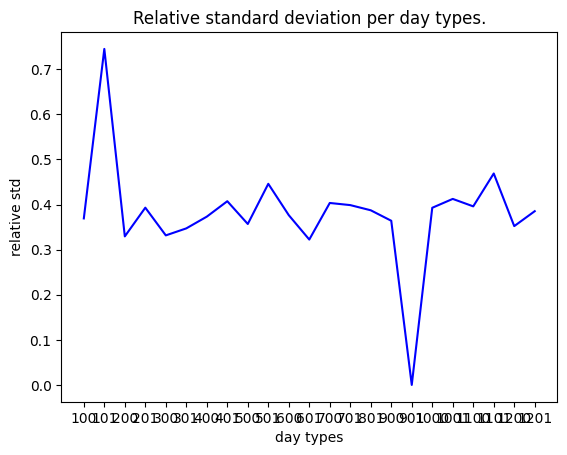

In [13]:
avg_model.train('basic', plot_rel_std=True)

In [14]:
avg_model.save('Covid_replaced_simplified_features_basic_avg_model')

In [73]:
avg_model = AverageModel2(train_data)
avg_model.load('Covid_replaced_simplified_features_basic_avg_model')
result = avg_model.infer(test_data)

missed_key_count = 1691


In [43]:
test_data = pd.read_csv('../data/test_data_day_typed_cov_replaced_simplified.csv')
test_data['date'] = pd.to_datetime(test_data['date'])
test_data

,index,date,month,week,day_name,day_numeric,station,day_type,day_full_type
0,2023-01-01_1J7,2023-01-01,1,52,Sunday,6,1J7,1,101
1,2023-01-01_O2O,2023-01-01,1,52,Sunday,6,O2O,1,101
2,2023-01-01_8QR,2023-01-01,1,52,Sunday,6,8QR,1,101
3,2023-01-01_L58,2023-01-01,1,52,Sunday,6,L58,1,101
4,2023-01-01_UMC,2023-01-01,1,52,Sunday,6,UMC,1,101
...,...,...,...,...,...,...,...,...,...
78647,2023-05-31_N9K,2023-05-31,5,22,Wednesday,2,N9K,0,500
78648,2023-05-31_P6E,2023-05-31,5,22,Wednesday,2,P6E,0,500
78649,2023-05-31_BDC,2023-05-31,5,22,Wednesday,2,BDC,0,500
78650,2023-05-31_QD6,2023-05-31,5,22,Wednesday,2,QD6,0,500


In [74]:
result = avg_model.infer(test_data)
avg_model.save_submission('submission_Covid_replaced_simplified_basic_avg')